In [26]:
import requests    # download the book 
import re
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import contractions
from itertools import combinations
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import networkx as nx
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohsenrahimi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
with open("book.txt", "r", encoding="utf-8") as f:
    book_content = f.read() 

    
start_phrase = "Chapter I.]"
end_phrase = "END OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE "

start_index = book_content.find(start_phrase)
end_index = book_content.find(end_phrase)

book_content = book_content[start_index:end_index]


In [28]:
book_content_with_last_chapter = book_content + "CHAPTER"

chapters = book_content_with_last_chapter.split("CHAPTER")
chapters.pop()

print(f"Total chapters: {len(chapters)}")


Total chapters: 60


In [52]:
def clean_chapter_content(chapter_content):
    return re.sub(r"[^a-zA-Z\s\n.,;!?'\"]", "", chapter_content)

chapters_clean = [clean_chapter_content(chapter) for chapter in chapters]

chapters_no_contractions = [contractions.fix(chapter) for chapter in chapters_clean]

chapters_continuous = [' '.join(chapter.splitlines()) for chapter in chapters_no_contractions]

chapters_sentences = [sent_tokenize(chapter) for chapter in chapters_continuous]


##   Create the NER pipeline

Use Hugging Face Transformers library to load a pre-trained Named Entity Recognition (NER) model based on BERT and create a NER pipeline for processing text.

In [31]:

# Load a pre-trained BERT-based NER model
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)    # Create a NER pipeline


def merge_subwords(entities):
    merged_entities = []
    for entity in entities:
        if entity["word"].startswith("##"):
            if len(merged_entities) > 0:
                merged_entities[-1]["word"] += entity["word"][2:]
        else:
            merged_entities.append(entity)
    return merged_entities



def is_valid_entity(entity):
    common_titles = ["Mrs", "Mr", "Miss", "Dr", "Sir", "Pope", "Lady", "."]
    stop_words = set(stopwords.words('english'))
    
    return (
        entity["entity"] == "I-PER"
        and entity["word"] not in common_titles
        and entity["word"] not in stop_words
        and len(entity["word"]) > 2  # Exclude single alphabets
    )



Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluation of NER
We can calculate the accuracy of the NER model by comparing the detected character names to a set of ground truth character names. For this, I need a list of correct character names from the text, which is created manually. 




Stages:

1. Create a set of ground truth character names.

2. Calculate true positives (TP), false positives (FP), and false negatives (FN).
- True Positives (TP): Named entities correctly identified by model
- False Positives (FP): Named entities incorrectly identified by model
- False Negatives (FN): Named entities missed by model

3. Calculate precision, recall, and F1-score.
 - Precision = TP / (TP + FP)
 - Recall = TP / (TP + FN)
 - F1 Score = 2 * (Precision * Recall) / (Precision + Recall)


In [32]:
unique_entities = set()
for chapter_idx, sentences in enumerate(chapters_sentences[:3]):
    print(f"Processing Chapter {chapter_idx + 1}")
    for sentence in sentences:
        # Extract named entities from the sentence
        entities = ner_pipeline(sentence)

        # Merge subwords and clean up the named entities
        merged_entities = merge_subwords(entities)

        # Filter out unwanted entity types and common titles
        filtered_entities = [entity for entity in merged_entities if is_valid_entity(entity)]

        # Add the named entities to the set
        for entity in filtered_entities:
            unique_entities.add(entity["word"])

# Print the unique named entities
print("Unique Named Entities:")
for entity in unique_entities:
    print(entity)



Processing Chapter 1
Processing Chapter 2
Processing Chapter 3
Unique Named Entities:
Bennets
Allen
Catherine
Lucas
Morris
King
Bennet
Lydia
Darcy
Lizzy
Elizabeth
Jane
Hurst
George
Maria
Long
Mary
William
Kitty
Bingley


In [141]:
detected_ner = list(unique_entities)
print("detected_NER:", detected_ner)

detected_NER: ['Bennets', 'Allen', 'Catherine', 'Lucas', 'Morris', 'King', 'Bennet', 'Lydia', 'Darcy', 'Lizzy', 'Elizabeth', 'Jane', 'Hurst', 'George', 'Maria', 'Long', 'Mary', 'William', 'Kitty', 'Bingley']


In [47]:
ground_truth_names=["Bennet", "Long", "George", "Morris", "Michaelmas", "Bingley", " Mrs.Bennet", "William", 
                    "Lucas", "Lizzy", "Jane", "Lydia", "Elizabeth", "Kitty", "Mary", "Hurst", "Darcy", "Catherine", 
                    "King", "Boulanger"]

In [140]:
def evaluate_ner_results(detected_ner, ground_truth_names):
    tp = set(detected_ner).intersection(ground_truth_names)
    fp = set(detected_ner).difference(ground_truth_names)
    fn = set(ground_truth_names).difference(detected_ner)

    evaluation_results = {
        "TP": len(tp),
        "FP": len(fp),
        "FN": len(fn),
        "true_positives": [list(tp)],
        "false_positives": [list(fp)],
        "false_negatives": [list(fn)],
    }
    
    return pd.DataFrame(evaluation_results)

def calculate_metrics(evaluation_results):
    precision = evaluation_results.at[0, "TP"] / (evaluation_results.at[0, "TP"] + evaluation_results.at[0, "FP"])
    recall = evaluation_results.at[0, "TP"] / (evaluation_results.at[0, "TP"] + evaluation_results.at[0, "FN"])
    f1_score = 2 * (precision * recall) / (precision + recall)

    metrics = {
        "precision": [precision],
        "recall": [recall],
        "f1_score": [f1_score],
    }
    
    return pd.DataFrame(metrics)

evaluation_results = evaluate_ner_results(detected_ner, ground_truth_names)
metrics = calculate_metrics(evaluation_results)
print("Evaluation Results of NER stage:")
display(evaluation_results)
print("Metrics:")
display(metrics)

Evaluation Results of NER stage:


,TP,FP,FN,true_positives,false_positives,false_negatives
0,17,3,3,"[George, Long, Bennet, Mary, Catherine, Darcy,...","[Maria, Bennets, Allen]","[Michaelmas, Mrs.Bennet, Boulanger]"


Metrics:


,precision,recall,f1_score
0,0.85,0.85,0.85


## co-occurrence matrix


To understand the relationships between characters, I perform a co-occurrence analysis by calculating how often two characters appear together within a certain window of words. This can be done using a sliding window approach, which moves through the text and counts co-occurrences within the window. This step is essential to quantify the strength of relationships between characters.

To create a co-occurrence matrix for each chapter, I do these steps:

1. Extract character names from each chapter as I did before.
2. Store character names in a set to avoid duplicates.
3. Create an empty co-occurrence matrix for each chapter.
4. For each pair of characters, count the number of times they co-occur within a specific window of sentences.
5. Fill the co-occurrence matrix with the counts.


In [49]:


# Window size for checking co-occurrences
window_size = 1

def get_character_names(sentences):
    character_names = set()
    for sentence in sentences:
        entities = ner_pipeline(sentence)
        merged_entities = merge_subwords(entities)
        filtered_entities = [entity for entity in merged_entities if is_valid_entity(entity)]
        for entity in filtered_entities:
            character_names.add(entity["word"])
    return character_names

def get_co_occurrences_matrix(chapter_sentences, character_names, window_size):
    name_to_index = {name: i for i, name in enumerate(character_names)}
    co_occurrences = np.zeros((len(character_names), len(character_names)), dtype=int)
    
    for i in range(len(chapter_sentences) - window_size + 1):
        window_sentences = chapter_sentences[i:i + window_size]
        window_characters = set()
        for sentence in window_sentences:
            entities = ner_pipeline(sentence)
            merged_entities = merge_subwords(entities)
            filtered_entities = [entity for entity in merged_entities if is_valid_entity(entity)]
            for entity in filtered_entities:
                window_characters.add(entity["word"])
        for a, b in combinations(window_characters, 2):
            co_occurrences[name_to_index[a], name_to_index[b]] += 1
            co_occurrences[name_to_index[b], name_to_index[a]] += 1

    return co_occurrences


In [50]:
t0=time()
chapter_co_occurrence_matrices = []

all_chapters_sentences = []
for sentences in chapters_sentences:
    all_chapters_sentences.extend(sentences)
    
print("Processing combined chapters")
character_names = get_character_names(all_chapters_sentences)
co_occurrences = get_co_occurrences_matrix(all_chapters_sentences, character_names, window_size)
chapter_co_occurrence_matrices.append(co_occurrences)
print("Co-occurrence matrix for the combined chapters:")
print(co_occurrences)
print()
t1=time()
print("The time it took to create the co-occurrence matrix in minutes: ", (t1-t0)/60)



Processing combined chapters
Co-occurrence matrix for the combined chapters:
[[0 0 0 ... 0 0 5]
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [5 2 0 ... 0 0 0]]

The time it took to create the co-occurrence matrix in minutes:  30.391440053780872


In [87]:
co_occurrences.shape

(107, 107)

### Creating the Graph 
`window_size =1` 

In [229]:
from IPython.display import clear_output
clear_output(wait=True)


G = nx.Graph()    # Create an empty graph

character_names_list = list(character_names) # Convert character_names to a list

G.add_nodes_from(character_names_list)

# Add edges to the graph with weights based on co-occurrence counts
for i in range(len(character_names_list)):
    for j in range(i + 1, len(character_names_list)):
        count = co_occurrences[i][j]
        if count > 0:  # Only add edges with non-zero counts
            G.add_edge(character_names_list[i], character_names_list[j], weight=count)

print(G)

Graph with 107 nodes and 360 edges


#### Creating the Graph 
`window_size =1` 

In [230]:
print(G)

Graph with 107 nodes and 360 edges


### Filter the nodes with weak connections < 3 

In [117]:
# Calculate the sum of co-occurrences for each character
co_occurrence_sum = np.sum(co_occurrences, axis=1)

threshold = 2

# Keep only characters with a co-occurrence sum greater than the threshold
important_characters_indices = np.where(co_occurrence_sum > threshold)[0]
important_characters = [character_names_list[i] for i in important_characters_indices]

# Create a new co-occurrence matrix with only the important characters
filtered_co_occurrences = co_occurrences[np.ix_(important_characters_indices, important_characters_indices)]


In [118]:
from IPython.display import clear_output
clear_output(wait=True)

import networkx as nx

G_filtered = nx.Graph() # Create an empty graph

# Add nodes to the graph
G_filtered.add_nodes_from(important_characters)

# Add edges to the graph with weights based on the filtered co-occurrence counts
for i in range(len(important_characters)):
    for j in range(i + 1, len(important_characters)):
        count = filtered_co_occurrences[i][j]
        if count > 0:  # Only add edges with non-zero counts
            G_filtered.add_edge(important_characters[i], important_characters[j], weight=count)
            


In [119]:
print(G)

Graph with 107 nodes and 360 edges


In [120]:
print(G_filtered)

Graph with 55 nodes and 320 edges


My initial graph contained of 107 nodes and 360 edges, representing a relatively dense network of character relationships. After filtering out weak connections (those with a co-occurrence value of 2 or less), I were left with a graph consisting of 55 nodes and 320 edges.

This filtered graph represents a more focused network of character relationships, emphasizing only the stronger connections between characters. By removing weak connections, I have eliminated minor and less significant relationships or some false identified charachters by NER, allowing for a clearer understanding of the main interactions and communities within the network.

The reduction from 107 nodes to 55 nodes while the majority of edges (320 out of 360) are still present after filtering indicates that the core structure of the network has been preserved, and the relationships among the central characters remain well-represented.



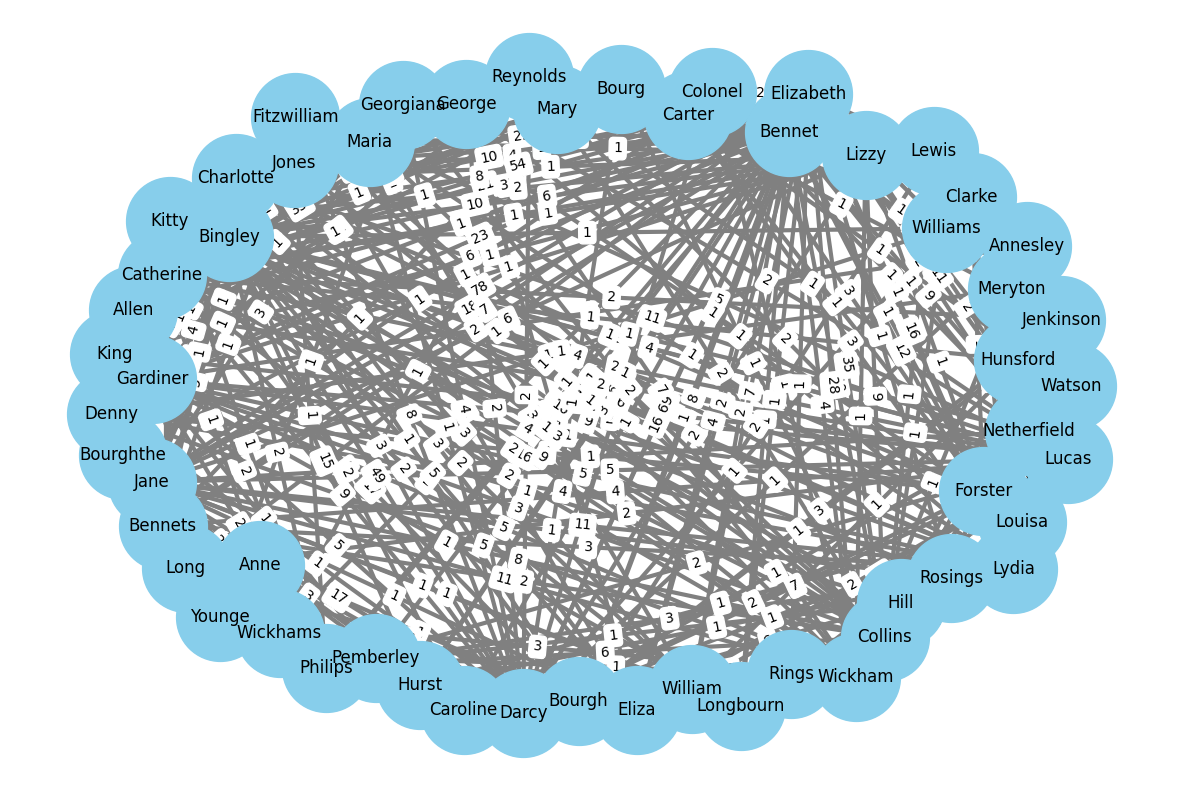

In [228]:
# Draw the graph
pos = nx.spring_layout(G_filtered, k=9)
fig, ax = plt.subplots(figsize=(15, 10))  # Increase the figure size
nx.draw(G_filtered, pos, with_labels=True, node_size=4000, font_size=12, node_color="skyblue", 
        edge_color="gray", width=3, ax=ax)
edge_labels = {(important_characters[i], important_characters[j]): filtered_co_occurrences[i][j] 
               for i in range(len(important_characters)) for j in range(i + 1, len(important_characters)) 
               if filtered_co_occurrences[i][j] > 0}
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=10, ax=ax)

plt.savefig("G.png", dpi=300, bbox_inches="tight")
plt.show()

### Centrality measurements
1. Degree centrality: Measures the number of direct connections a node has.
2. Closeness centrality: Measures how close a node is to all other nodes in the graph.
3. Betweenness centrality: Measures the number of shortest paths that pass through a node.
4. Eigenvector centrality: Measures the importance of a node based on the importance of its neighbors.

In [122]:
#Now calculate the centrality measures for each character node in the graph

degree_centrality = nx.degree_centrality(G_filtered)
closeness_centrality = nx.closeness_centrality(G_filtered)
betweenness_centrality = nx.betweenness_centrality(G_filtered)
eigenvector_centrality = nx.eigenvector_centrality(G_filtered)


# sort the characters by their centrality values, to find the most important and influential characters based on each centrality measure 
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

### Degree Distribution
**Does our network follow a power-law distribution?**


Degree distribution is a concept used in network analysis to describe the probability distribution of the degrees (number of connections) over all the nodes (entities) in a network. In simple terms, it is a way to represent how many connections each node in the network has and how these connections are distributed among all the nodes.

In the context of novels study, the degree distribution represents how character relationships are distributed within the social network formed by the characters. A high degree for a character node means that the character has many connections (relationships) with other characters, while a low degree indicates fewer connections. By analyzing the degree distribution of the networks, we can gain insights into the structure of character relationships and the prominence of certain characters in the novels.

A power-law distribution is a type of probability distribution that exhibits a specific mathematical relationship between the quantity being measured (in my case, the degree of nodes in a network) and the frequency of that quantity. 

When a network is said to follow a power-law distribution, it implies that the network has a few highly connected nodes, called "hubs," while the majority of the nodes have relatively fewer connections. This property is often observed in real-world networks, such as social networks, where some individuals have a large number of connections while most have only a few connections.

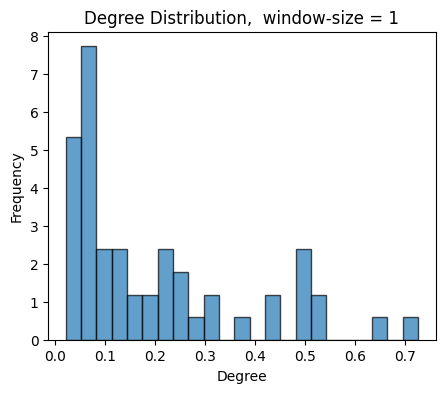

In [241]:
# Degree Distribution
degree_values = [v for k, v in degree_centrality.items()]  # degree_values is equal to degree_centrality
degree_distribution = np.histogram(degree_values, bins=len(set(degree_values)), density=True)
hist, bin_edges = degree_distribution

plt.figure(figsize=(5, 4))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution,  window-size = 1")
plt.savefig("Degree Distribution1.png", dpi=300, bbox_inches="tight")
plt.show()

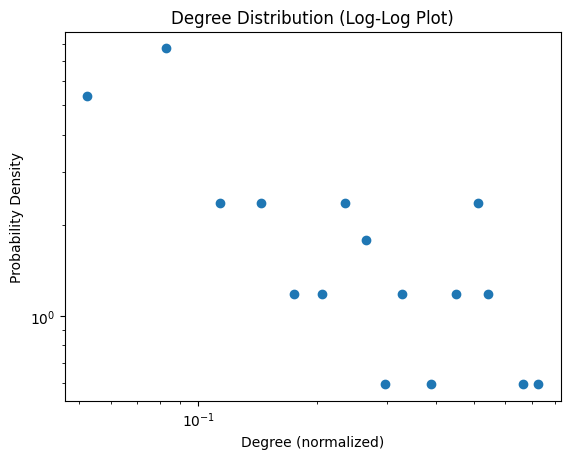

In [124]:
# Logarithmic binning
bins = degree_distribution[1]
bin_centers = (bins[:-1] + bins[1:]) / 2
hist_values = degree_distribution[0]

# Remove zero values for log-log plotting
non_zero_indices = hist_values > 0
bin_centers = bin_centers[non_zero_indices]
hist_values = hist_values[non_zero_indices]

# Log-log plot
plt.plot(bin_centers, hist_values, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (normalized)')
plt.ylabel('Probability Density')
plt.title('Degree Distribution (Log-Log Plot)')

plt.show()


**To further confirm that our network follows a power-law distribution,**
I can fit a linear model to the log-log data and compute the goodness-of-fit, such as the `R-squared` value. A high R-squared value (close to 1) indicates that the power-law model fits our data well, providing stronger evidence that our network follows a power-law distribution or not?

In a log-log plot, the x-axis represents the degree (normalized) and the y-axis represents the probability density of that degree occurring in the network.

A negative linear relationship implies that as the degree increases, the probability density of that degree occurring in the network decreases, But the value of R-squared is 0.61, which sugests that this network does not follow a power-law distribution strongly.




 

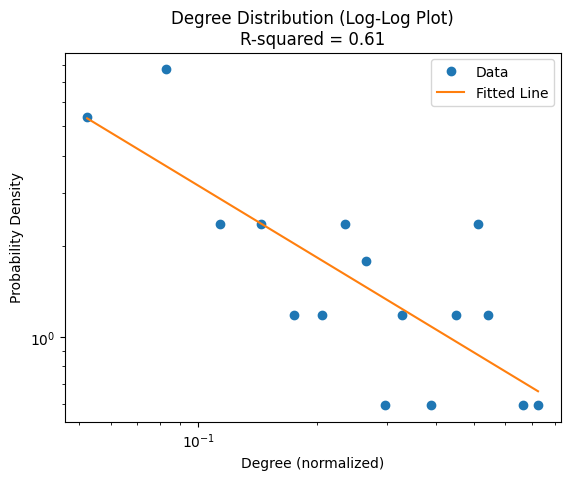

In [242]:
# Logarithmic binning
bins = degree_distribution[1]
bin_centers = (bins[:-1] + bins[1:]) / 2
hist_values = degree_distribution[0]

# Remove zero values for log-log plotting
non_zero_indices = hist_values > 0
bin_centers = bin_centers[non_zero_indices]
hist_values = hist_values[non_zero_indices]

# Fit a linear model
log_centers = np.log10(bin_centers)
log_values = np.log10(hist_values)
coefficients = np.polyfit(log_centers, log_values, 1)
linear_fit = np.poly1d(coefficients)

# Calculate R-squared
correlation_matrix = np.corrcoef(log_centers, log_values)
correlation_coefficient = correlation_matrix[0, 1]
r_squared = correlation_coefficient ** 2

# Log-log plot with fitted line
plt.plot(bin_centers, hist_values, 'o', label='Data')
plt.plot(bin_centers, 10 ** linear_fit(log_centers), label='Fitted Line')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (normalized)')
plt.ylabel('Probability Density')
plt.title(f'Degree Distribution (Log-Log Plot)\nR-squared = {r_squared:.2f}')
plt.legend()
plt.savefig("Degree Distribution.png", dpi=300, bbox_inches="tight")
plt.show()


#### Modify
The R-squared values you obtained (0.88 and 0.73) represent the goodness-of-fit of the power-law model to your network data when using different window sizes for tokenizing your book and creating the co-occurrence matrix.

An R-squared value of 0.88 with a window size of 1 indicates that the power-law model explains 88% of the variance in your log-log degree distribution data. This suggests that your network follows a power-law distribution quite well when using a window size of 1.

On the other hand, an R-squared value of 0.74 with a window size of 3 indicates that the power-law model explains 73% of the variance in your log-log degree distribution data. This is a lower goodness-of-fit compared to the window size of 1, but it suggests that our network exhibits power-law characteristics to some extent.

The difference in R-squared values between the window sizes implies that the choice of window size affects the degree distribution and the power-law property of my network. A larger window size might capture more local character relationships within sentences, leading to a stronger power-law property, while a smaller window size  might capture more global character relationships across sentences, which could dilute the power-law property to some extent.

In summary, both window sizes show evidence of a power-law distribution in your network, with the window size of 1 resulting in a stronger power-law property. It is essential to consider the trade-offs and implications of different window sizes when interpreting the network properties and the underlying character relationships in your book.

The degree distribution of two networks and their log-log plots are depicted in Figures ​Figures--- and ​and---, respectively. According to the figures, degree distribution of both networks follow a power-law distribution—a significant property of the real-world network.

## Network density

Network density is a measure of the overall connectivity of a network. It represents the proportion of actual edges in the network to the maximum possible number of edges between all nodes. A high network density indicates that the network is highly interconnected, while a low network density suggests that the network is sparse.

**Network density and power-law distribution:**

In some cases, a network with a low density can still exhibit a power-law distribution if the majority of nodes have few connections and only a small number of nodes have many connections. Conversely, a network with a high density can also show a power-law distribution if the connectivity is distributed in a way that still creates a heavy tail in the degree distribution.

In summary, network density and the power-law model describe different aspects of a network and are not directly connected. However, they can provide complementary information about the connectivity and structure of the network, helping you better understand and interpret the network's properties.


In [244]:
# Network Density
network_density = nx.density(G_filtered)
print(f"Network Density window-size = 1  is  {network_density}")

Network Density window-size = 1  is  0.21548821548821548


### Modify
The network density values you obtained (0.0625 for window_size=1 and 0.1166 for window_size=3) provide insight into the connectivity of the character relationships in your book, given different window sizes.

A network density of 0.0625 when window_size=1 indicates that about 6.25% of all possible character relationships (edges) are present in the network. This suggests that the network is relatively sparse, with most characters having few connections with each other.

A network density of 0.1166 when window_size=3 indicates that about 11.66% of all possible character relationships (edges) are present in the network. This value is higher than the density for window_size=1, suggesting that the network is more interconnected when using a larger window size. This is expected since a larger window size captures more global character relationships across sentences, leading to a higher number of edges in the network.

It is essential to consider the implications of different window sizes on network density when interpreting the connectivity of character relationships in your book. A smaller window size (e.g., 1) might capture more local character relationships within sentences, resulting in a sparser network, while a larger window size (e.g., 3) might capture more global character relationships across sentences, leading to a denser network. It's worth noting that network density alone does not provide information about the power-law distribution of the network, but it can be a useful complementary measure to understand the overall connectivity of the network.

## Number of connected components in the network

In [246]:
# Find the connected components
connected_components = list(nx.connected_components(G_filtered))

# Initialize lists to store data for the DataFrame
component_nodes = []
component_sizes = []
average_shortest_path_lengths = []
diameters = []

# Calculate the average shortest path length and diameter for each connected component
for component in connected_components:
    subgraph = G.subgraph(component)
    average_shortest_path_length = nx.average_shortest_path_length(subgraph)
    diameter = nx.diameter(subgraph)
    
    component_nodes.append(list(component))
    component_sizes.append(subgraph.number_of_nodes())
    average_shortest_path_lengths.append(average_shortest_path_length)
    diameters.append(diameter)

components_df = pd.DataFrame(
    {
        "Component Nodes": component_nodes,
        "Component Size": component_sizes,
        "Average Shortest Path Length": average_shortest_path_lengths,
        "Diameter": diameters,
       
    }
)

# Print the DataFrame
#components_df.head(3)
print("window-size = 1")
display(components_df)

window-size = 1


,Component Nodes,Component Size,Average Shortest Path Length,Diameter
0,"[Williams, Bennets, Gardiner, Catherine, Allen...",55,1.901684,3


This DataFrame shows the connected components for the character co-occurrence network with window-size = 1. Each row represents a connected component, and the columns provide information about the component nodes, component size, and average shortest path length and diameter length within the component.

The first connected component (row 0) is the largest, containing 84 nodes (characters). The average shortest path length for this component is about 2.29, indicating that, on average, any two characters within this component can be connected through about 2 to 3 steps. This component likely represents the main group of characters in the book who interact with each other.

The remaining connected components (rows 1-24) are much smaller, with most of them containing only one node. These isolated components represent characters who have no connections with other characters within the window-size = 1.
The average shortest path length for these components is either 0 (for single nodes) or 1 (for two nodes connected directly). These components might represent minor characters who have limited interactions with the main group of characters or characters who are only mentioned but do not have any direct relationships with other characters in the book, or they might be some errors from NER stage, so I do not consider them to calculate `Average diameter` and `Average Shortest Path Length`. 

In summary, the DataFrame suggests that the majority of character relationships are contained within the largest connected component, while several smaller components represent isolated or peripheral characters in the book. The relatively low average shortest path length for the largest component indicates that the main group of characters is fairly interconnected, with short paths connecting any pair of characters.


In [128]:
# Exclude single-node components
filtered_component_sizes = [size for size in component_sizes if size > 1]
filtered_diameters = [diameter for diameter, size in zip(diameters, component_sizes) if size > 1]
filtered_average_shortest_path_lengths = [
    path_length for path_length, size in zip(average_shortest_path_lengths, component_sizes) if size > 1
]

# Calculate the weighted average diameter (excluding single-node components)
weighted_average_diameter = np.average(filtered_diameters, weights=filtered_component_sizes)
print(f"Weighted average diameter (excluding single-node components): {weighted_average_diameter}")

# Compute the weighted average of the average shortest path lengths (excluding single-node components)
weighted_average_shortest_path_length = np.average(
    filtered_average_shortest_path_lengths, weights=filtered_component_sizes
)

print(f"\nWeighted Average Shortest Path Length (excluding single-node components): \
{weighted_average_shortest_path_length}")





Weighted average diameter (excluding single-node components): 3.0

Weighted Average Shortest Path Length (excluding single-node components): 1.9016835016835016


### Modify
The weighted average diameter (excluding single-node components) you calculated for two different window sizes provides insights into the structure of the character co-occurrence network.

When the window size is 1, the weighted average diameter is 4.6989. This means that on average, considering the connected components with more than one node, it takes about 4.7 steps to get from one character to another. In this case, the co-occurrence network has a more detailed and fine-grained structure, as characters are considered to be connected if they co-occur within a single word distance.

On the other hand, when the window size is 3, the weighted average diameter is 4.0. This indicates that the average distance between characters in connected components with more than one node has decreased. With a larger window size, more character connections are captured, as characters are considered to be connected if they co-occur within a three-word distance. As a result, the overall interconnectedness of the co-occurrence network increases, leading to shorter average distances between characters.

These results suggest that as the window size increases, the character co-occurrence network becomes more interconnected, and the average distance between characters decreases. This is expected, as a larger window size allows for more connections between characters based on their co-occurrence within the text.

### clustering coefficient

In [143]:
clustering_coefficient = nx.clustering(G_filtered)

average_clustering_coefficient = nx.average_clustering(G_filtered)

print(f"Average Clustering Coefficient: {average_clustering_coefficient}")

# Create a DataFrame from the clustering_coefficient dictionary
clustering_coefficient_df = pd.DataFrame.from_dict(
    clustering_coefficient, orient='index', columns=['Clustering Coefficient']
)

# Sort the DataFrame by Clustering Coefficient in descending order (large to small)
sorted_clustering_coefficient_df = clustering_coefficient_df.sort_values(
    by=['Clustering Coefficient'], ascending=False
)

# Round the values in the DataFrame to 2 decimal places
rounded_sorted_clustering_coefficient_df = sorted_clustering_coefficient_df.round(2)

# Print the sorted and rounded DataFrame with Clustering Coefficient for each node
#rounded_sorted_clustering_coefficient_df

Average Clustering Coefficient: 0.7619295745910324


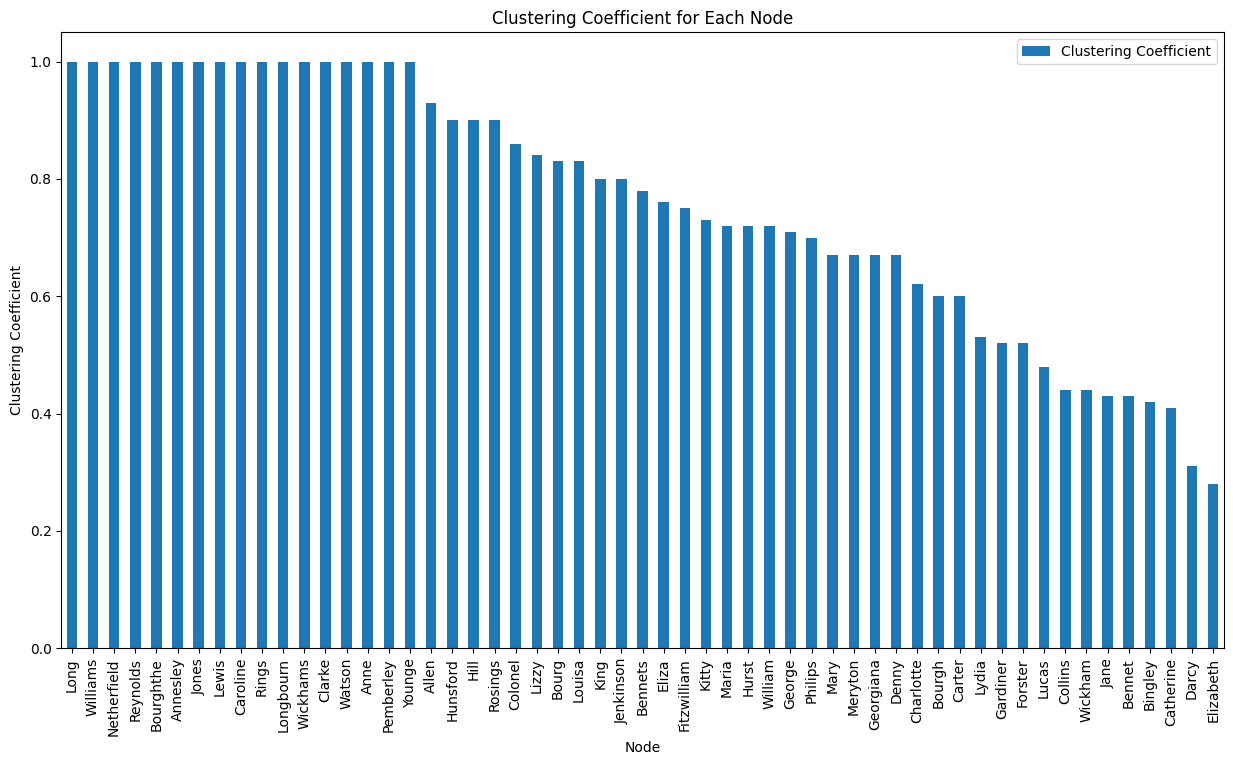

In [130]:
# Create a bar plot of the Clustering Coefficient for each node
fig, ax = plt.subplots(figsize=(15, 8))
rounded_sorted_clustering_coefficient_df.plot(kind='bar', ax=ax)

# Set the title and labels
ax.set_title('Clustering Coefficient for Each Node')
ax.set_xlabel('Node')
ax.set_ylabel('Clustering Coefficient')

# Show the plot
plt.show()

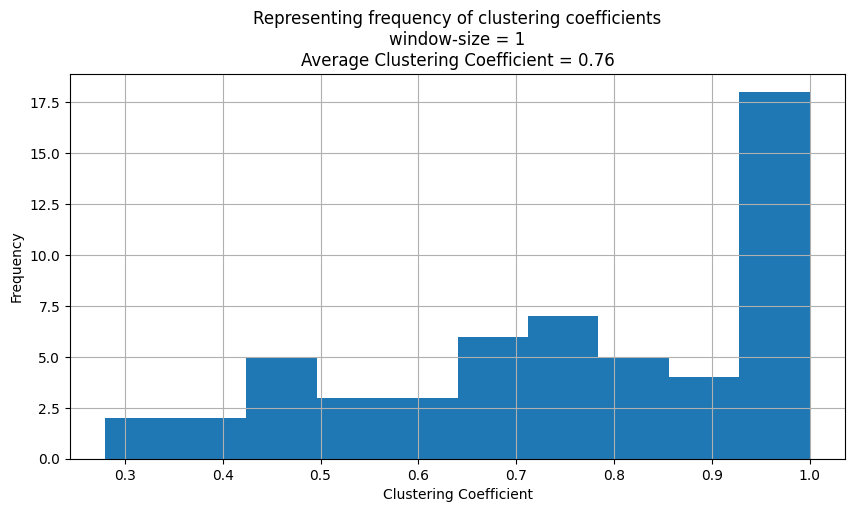

In [247]:
# Create a histogram of the Clustering Coefficient with 10 bins
fig, ax = plt.subplots(figsize=(10, 5))
rounded_sorted_clustering_coefficient_df.hist(bins=10, ax=ax)

# Set the title and labels
ax.set_title(f'Representing frequency of clustering coefficients\nwindow-size = 1\nAverage Clustering Coefficient = {average_clustering_coefficient:.2f}')
ax.set_xlabel('Clustering Coefficient')
ax.set_ylabel('Frequency')

plt.savefig("Clustering Coefficient.png", dpi=300, bbox_inches="tight")
plt.show()

This code snippet creates a histogram using the sorted and rounded DataFrame containing the clustering coefficient for each node. The histogram has 10 bins, and it shows the distribution of clustering coefficients across all nodes in the graph. The x-axis represents the clustering coefficient, and the y-axis represents the frequency of nodes with a given clustering coefficient.

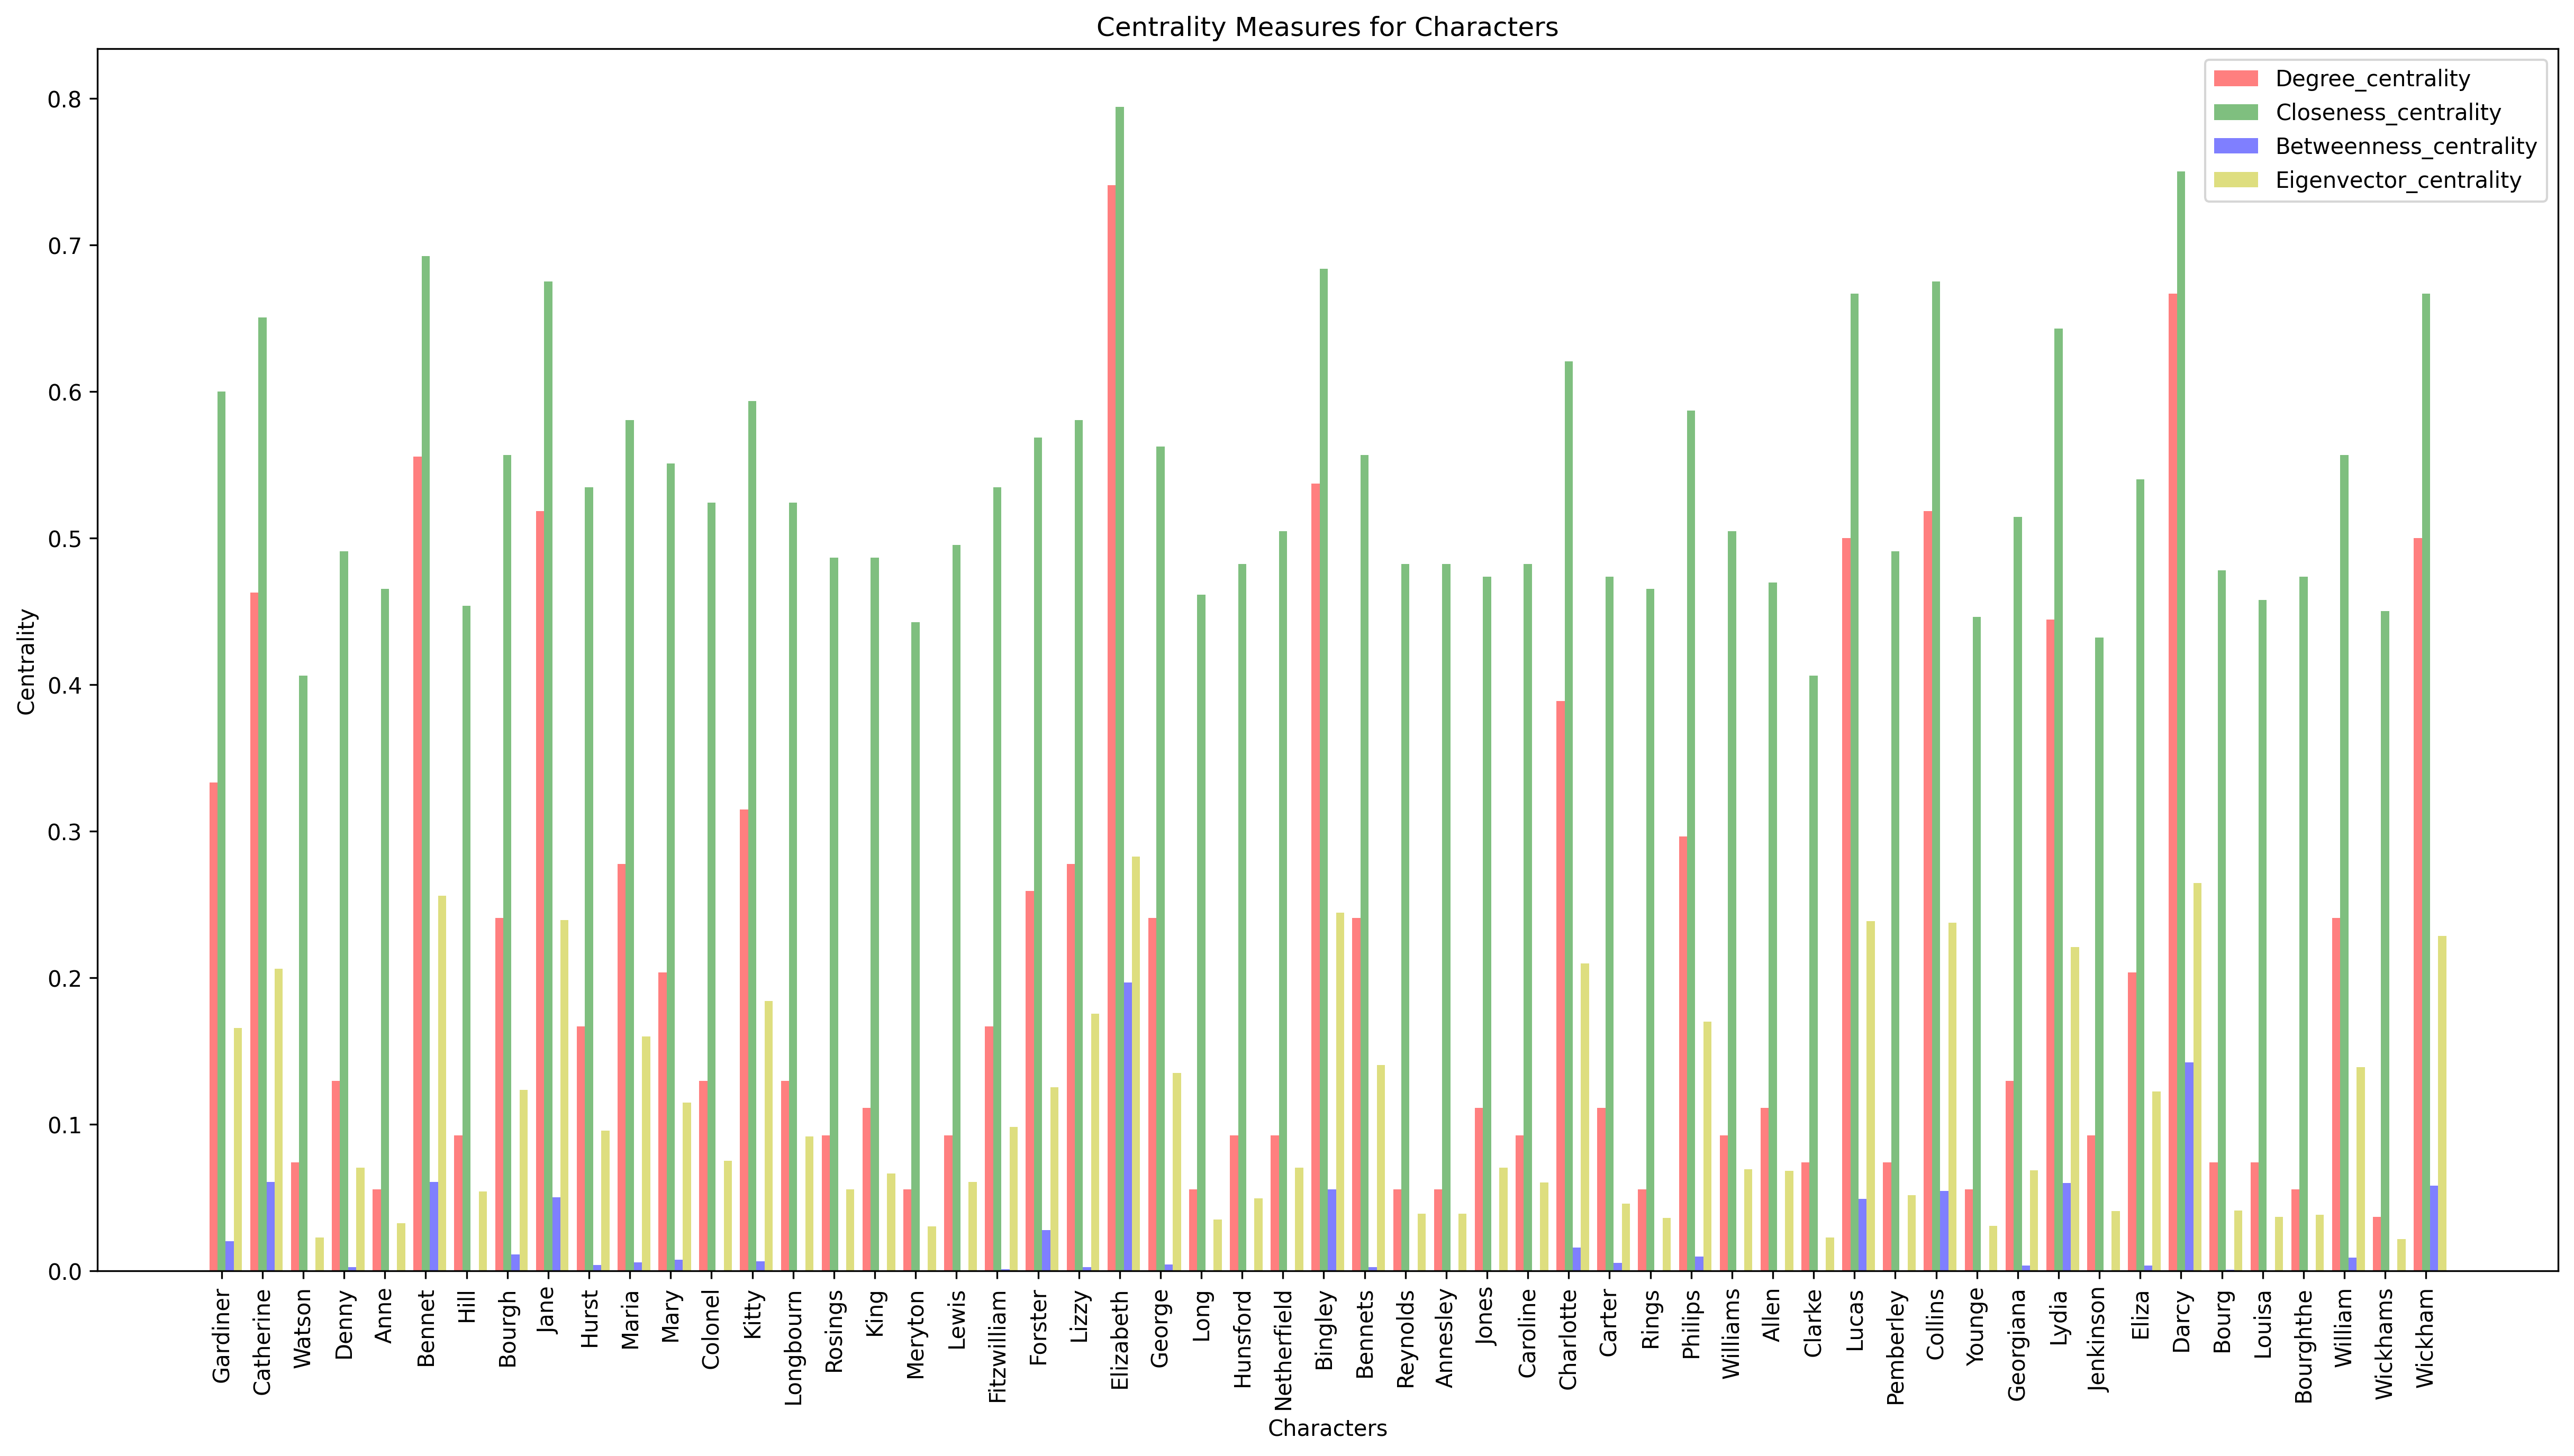

In [145]:

characters = list(degree_centrality.keys())
degree_values = list(degree_centrality.values())
closeness_values = list(closeness_centrality.values())
betweenness_values = list(betweenness_centrality.values())
eigenvector_values = list(eigenvector_centrality.values())

# Set up the bar chart
num_characters = len(characters)
bar_width = 0.2
x_pos = np.arange(num_characters)

plt.figure(figsize=(20, 10), dpi=300)
plt.bar(x_pos, degree_values, bar_width, alpha=0.5, color='r', label='Degree_centrality')
plt.bar(x_pos + bar_width, closeness_values, bar_width, alpha=0.5, color='g', label='Closeness_centrality')
plt.bar(x_pos + 2 * bar_width, betweenness_values, bar_width, alpha=0.5, color='b', label='Betweenness_centrality')
plt.bar(x_pos + 3 * bar_width, eigenvector_values, bar_width, alpha=0.5, color='y', label='Eigenvector_centrality')

plt.xticks(x_pos + bar_width, characters, rotation=90, fontsize=10)
plt.xlabel('Characters')
plt.ylabel('Centrality')
plt.title('Centrality Measures for Characters')
plt.legend()
plt.savefig("centrality_measures_w1.png", dpi=300, bbox_inches="tight")
plt.show()

/Users/mohsenrahimi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3600x3600 with 0 Axes>

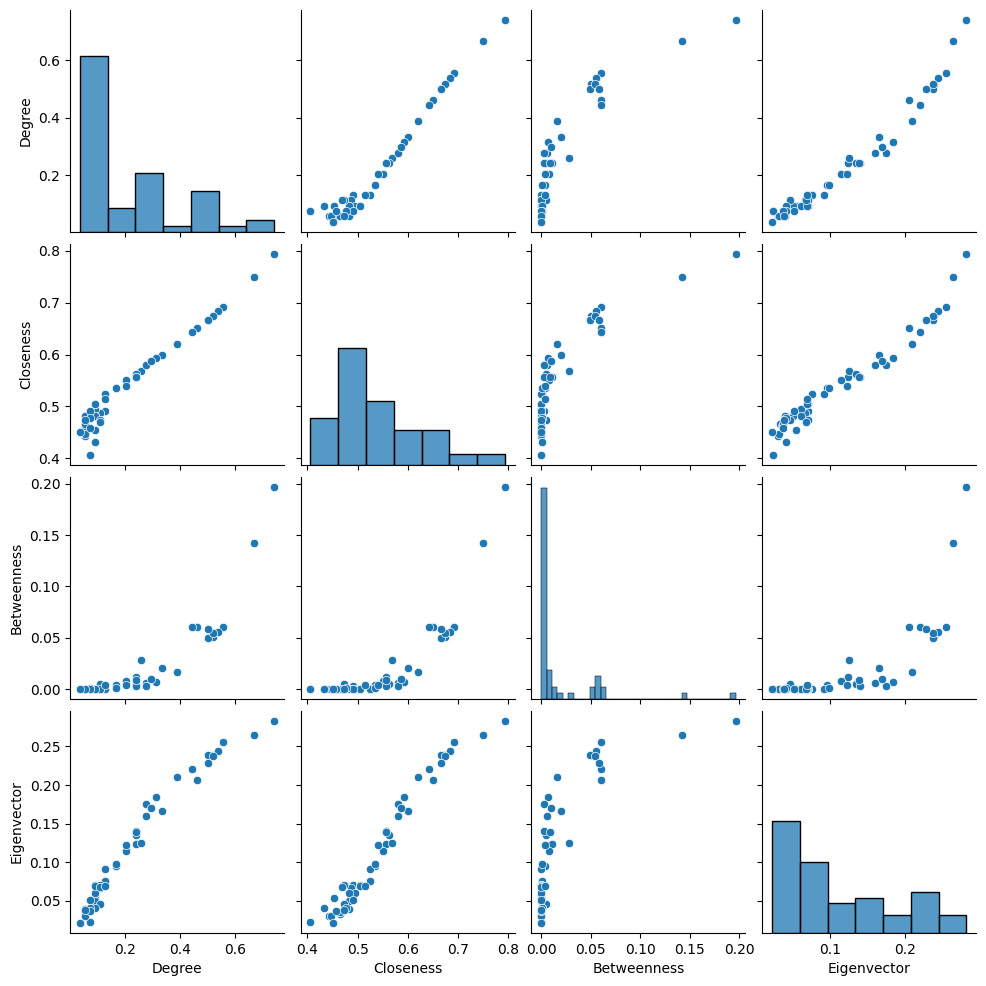

In [163]:


# Assuming you have calculated the centrality measures as dictionaries
centrality_data = {'Degree': degree_centrality, 'Closeness': closeness_centrality,
                   'Betweenness': betweenness_centrality, 'Eigenvector': eigenvector_centrality}

df = pd.DataFrame(centrality_data)
plt.figure(figsize=(12, 12), dpi=300)
# Create the scatter plot matrix
sns.pairplot(df)
plt.savefig("all_cntrality.png", dpi=300, bbox_inches="tight")
plt.show()

In [237]:


# Create a data frame with the sorted centrality values
centrality_df = pd.DataFrame({
    "Character": [character for character, value in sorted_degree],
    "Degree": [value for character, value in sorted_degree],
    "Closeness": [closeness_centrality[character] for character, value in sorted_degree],
    "Betweenness": [betweenness_centrality[character] for character, value in sorted_degree],
    "Eigenvector": [eigenvector_centrality[character] for character, value in sorted_degree]
})

# Show the data frame





In [239]:
centrality_df

,Character,Degree,Closeness,Betweenness,Eigenvector
0,Elizabeth,0.740741,0.794118,0.196639,0.282788
1,Darcy,0.666667,0.750000,0.142326,0.264769
2,Bennet,0.555556,0.692308,0.060788,0.256065
3,Bingley,0.537037,0.683544,0.055476,0.244504
4,Jane,0.518519,0.675000,0.050343,0.239325
5,Collins,0.518519,0.675000,0.054659,0.237754
6,Lucas,0.500000,0.666667,0.049251,0.238630
7,Wickham,0.500000,0.666667,0.058252,0.228477
8,Catherine,0.462963,0.650602,0.060693,0.206329
9,Lydia,0.444444,0.642857,0.059977,0.221022


In [232]:
# Calculate the average centrality
centrality_df['Average'] = centrality_df[['Degree', 'Closeness', 'Betweenness', 'Eigenvector']].mean(axis=1)

# Sort the DataFrame by the average centrality in descending order
sorted_data = centrality_df.sort_values(by='Average', ascending=False)

# Select the top 15 characters
top_15_characters = sorted_data
top_15_characters


,Character,Degree,Closeness,Betweenness,Eigenvector,Average
0,Elizabeth,0.740741,0.794118,0.196639,0.282788,0.503571
1,Darcy,0.666667,0.750000,0.142326,0.264769,0.455940
2,Bennet,0.555556,0.692308,0.060788,0.256065,0.391179
3,Bingley,0.537037,0.683544,0.055476,0.244504,0.380140
5,Collins,0.518519,0.675000,0.054659,0.237754,0.371483
4,Jane,0.518519,0.675000,0.050343,0.239325,0.370797
6,Lucas,0.500000,0.666667,0.049251,0.238630,0.363637
7,Wickham,0.500000,0.666667,0.058252,0.228477,0.363349
8,Catherine,0.462963,0.650602,0.060693,0.206329,0.345147
9,Lydia,0.444444,0.642857,0.059977,0.221022,0.342075


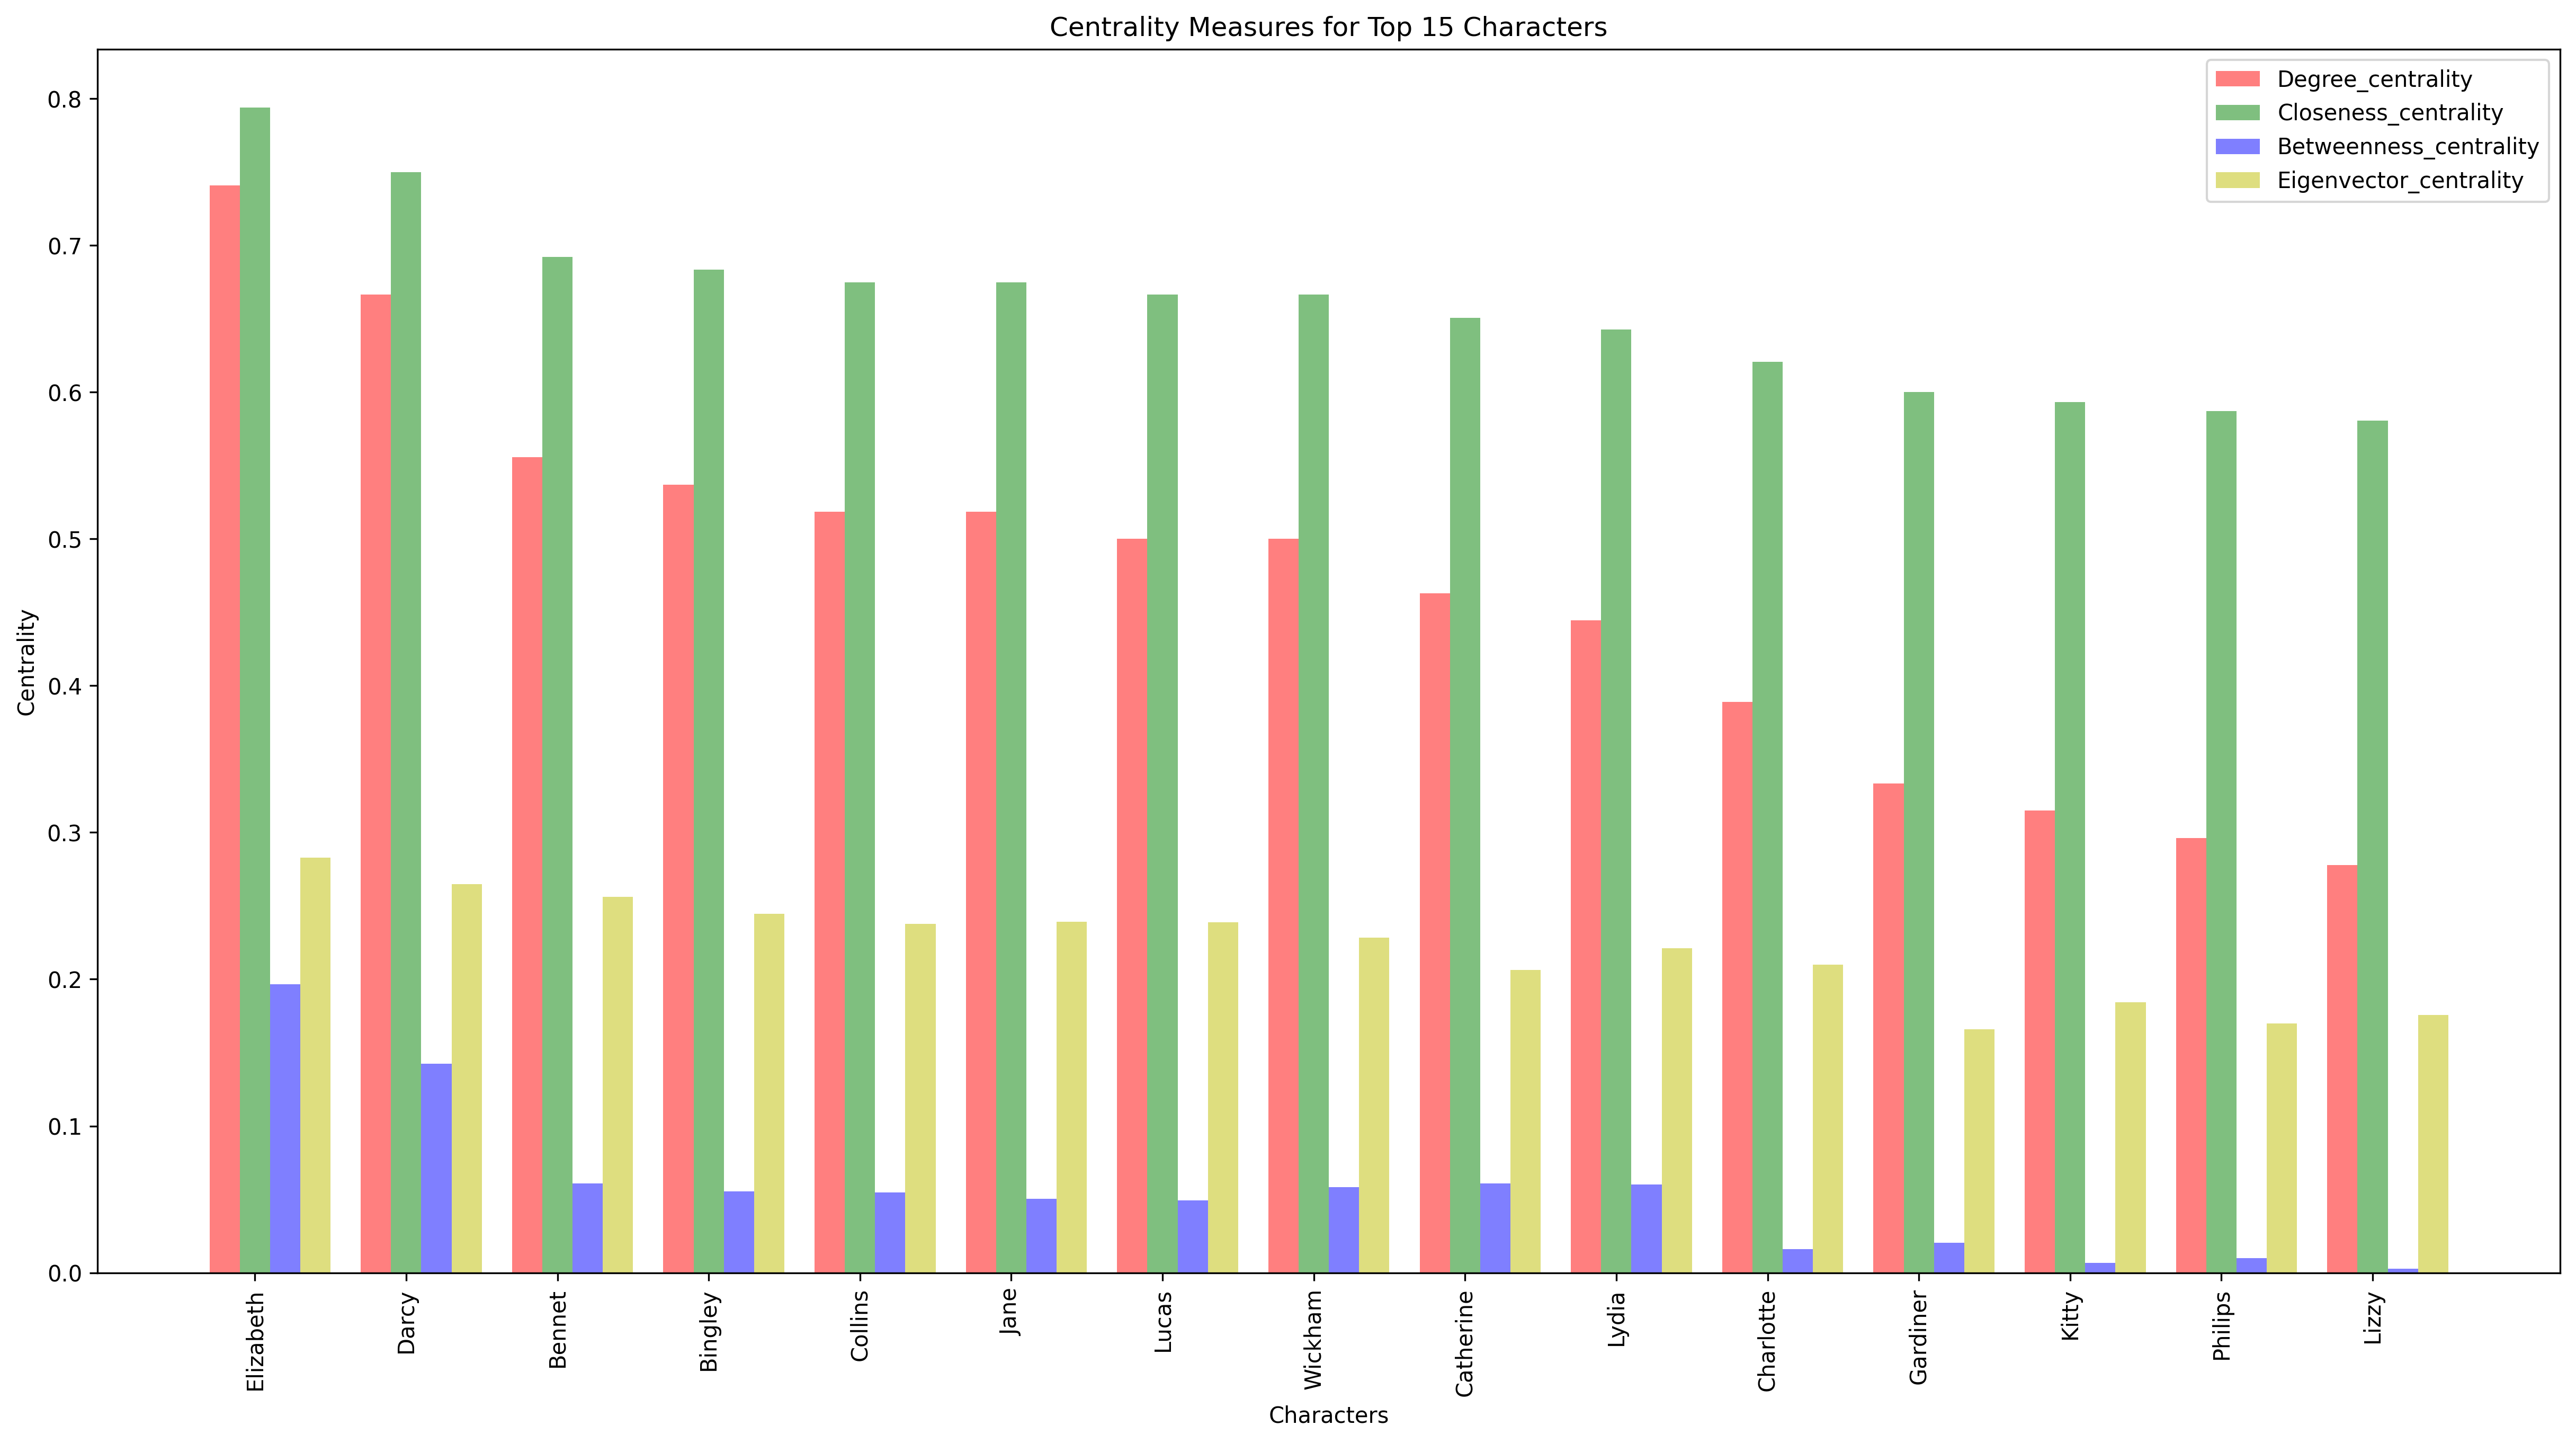

In [156]:
# Select the top 15 characters
top_15_characters = sorted_data.head(15)

# Prepare the data
x_pos = np.arange(len(top_15_characters))
degree_values = top_15_characters["Degree"]
closeness_values = top_15_characters["Closeness"]
betweenness_values = top_15_characters["Betweenness"]
eigenvector_values = top_15_characters["Eigenvector"]
characters = top_15_characters["Character"]

bar_width = 0.2

# Create the bar plot
plt.figure(figsize=(20, 10), dpi=300)
plt.bar(x_pos, degree_values, bar_width, alpha=0.5, color='r', label='Degree_centrality')
plt.bar(x_pos + bar_width, closeness_values, bar_width, alpha=0.5, color='g', label='Closeness_centrality')
plt.bar(x_pos + 2 * bar_width, betweenness_values, bar_width, alpha=0.5, color='b', label='Betweenness_centrality')
plt.bar(x_pos + 3 * bar_width, eigenvector_values, bar_width, alpha=0.5, color='y', label='Eigenvector_centrality')

plt.xticks(x_pos + bar_width, characters, rotation=90, fontsize=10)
plt.xlabel('Characters')
plt.ylabel('Centrality')
plt.title('Centrality Measures for Top 15 Characters')
plt.legend()

# Save the plot as an image
plt.savefig("top_15_centrality_measures_plot.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

1. Degree Centrality: Degree centrality measures the number of direct connections a character has. Characters with high degree centrality are well-connected and have more relationships with other characters. Elizabeth, Darcy, and Bennet have the highest degree centrality, which suggests that they have the most significant number of direct connections with other characters.

2. Closeness Centrality: Closeness centrality measures how close a character is to all other characters in the network. Characters with high closeness centrality can quickly interact or influence other characters. Elizabeth and Darcy have the highest closeness centrality, indicating that they can easily communicate or reach other characters in the network.

3. Betweenness Centrality: Betweenness centrality measures the extent to which a character lies on the shortest path between other characters. Characters with high betweenness centrality act as bridges or intermediaries within the network. Elizabeth has the highest betweenness centrality, suggesting that she plays a crucial role in connecting different groups or sub-networks of characters.

4. Eigenvector Centrality: Eigenvector centrality measures the influence of a character based on the quality of their connections. Characters with high eigenvector centrality have connections with other influential characters. In this case, the eigenvector centrality values are relatively close for the top 15 characters. This suggests that the characters are connected with similarly influential characters, and their overall influence in the network is not vastly different.

In summary, Elizabeth, Darcy, and Bennet are the most outstanding characters in the network based on the centrality measures. They have the most direct connections, are closer to other characters, and act as bridges within the network. Additionally, the eigenvector centrality values show that these characters are connected with similarly influential characters, which further establishes their importance in the network.

### Community detection
is a technique used to identify groups or clusters of nodes in a network that are more densely connected with each other than with nodes outside the group. Several algorithms can be used for community detection, including Louvain, Girvan-Newman, and Walktrap. I'll provide examples of how to apply these three algorithms to a network using Python and the `networkx` and `community` libraries.



By applying these community detection algorithms to your network, you can identify clusters of characters that are more closely related. This can help you understand different groups or factions within the story and reveal interesting patterns or social groups in the story. Remember to interpret the results in the context of your network and the problem you're trying to analyze.

# girvan_newman

In [216]:
import networkx as nx
from networkx.algorithms.community import girvan_newman

communities_generator = girvan_newman(G)
# Get the first level of communities (I can call next() again for more refined communities)
communities = next(communities_generator)
# The communities variable is a list of sets, each set representing a community
print(communities)

({'Gardiner', 'Catherine', 'Watson', 'Denny', 'Woods', 'Anne', 'Bennet', 'Kingtheres', 'Metcalfe', 'Hill', 'Bourgh', 'Jane', 'Hurst', 'Maria', 'Yesif', 'Mary', 'Colonel', 'Nicholls', 'Fitzwilliams', 'Kitty', 'Darcys', 'Janes', 'Sarah', 'Longbourn', 'Jenkins', 'Rosings', 'Charles', 'King', 'Meryton', 'Lewis', 'Fitzwilliam', 'Miller', 'Forster', 'Lizzy', 'Elizabeth', 'George', 'All', 'Hunsford', 'Netherfield', 'Bingley', 'Bennets', 'Goulding', 'Reynolds', 'Annesley', 'Jones', 'Caroline', 'Charlotte', 'Carter', 'Rings', 'Longurn', 'Wickhamickham', 'Philips', 'Williams', 'Allen', 'Clarke', 'Lucas', 'Pemberley', 'Collins', 'Younge', 'Bourghs', 'Georgiana', 'John', 'Lydia', 'Jenkinson', 'Eliza', 'Richard', 'Darcy', 'Bourg', 'Lizzie', 'Pratt', 'Louisa', 'Bourghthe', 'William', 'Wickhams', 'Catherines', 'March', 'Wickham'}, {'Stone'}, {'Long', 'Morris', 'Gouldings'}, {'Janeone'}, {'Dawson'}, {'Harriet', 'Pen', 'Harrington'}, {'Gardiners'}, {'Lydias'}, {'Haggerston'}, {'Annes'}, {'Grantley'}, {

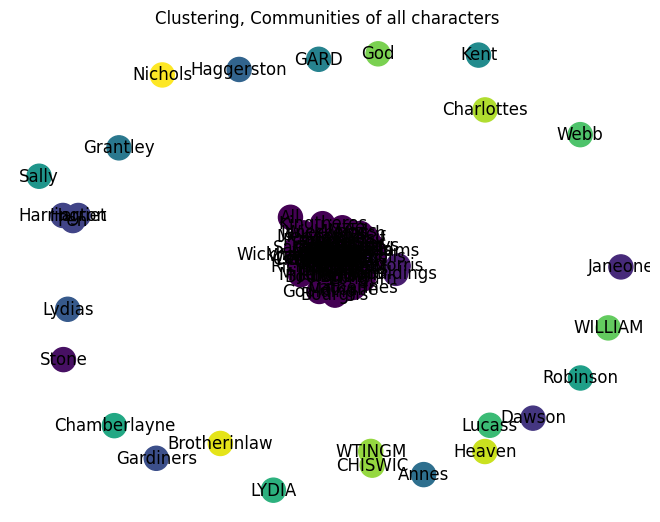

In [218]:
# Function to map colors to the nodes
def map_colors(node, communities):
    for i, community in enumerate(communities):
        if node in community:
            return i
    return -1

# Create a new figure
plt.figure()

# Set the position of nodes using a spring layout
pos = nx.spring_layout(G)

# Draw the nodes with different colors for different communities
nx.draw(G, pos, node_color=[map_colors(node, communities) for node in G.nodes()], with_labels=True)

# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.title('Clustering, Communities of all characters ')
plt.savefig("Clustering, all Communities.png", dpi=300, bbox_inches="tight")
plt.show()

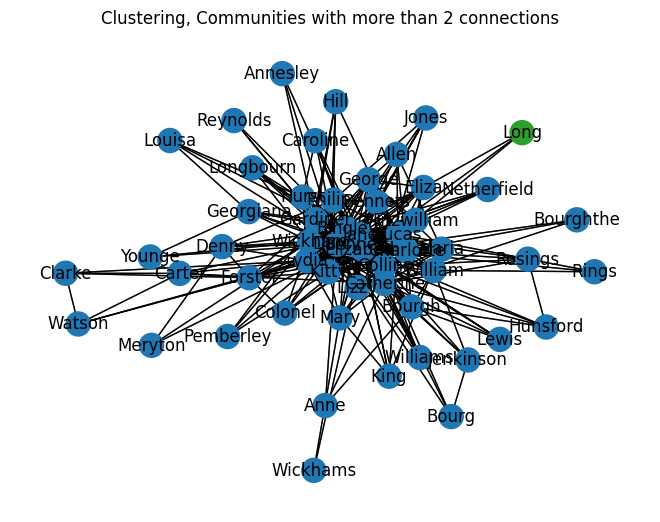

In [217]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



# Create a new figure
plt.figure()

# Set the position of nodes using a spring layout
pos = nx.spring_layout(G_filtered)

# Generate a list of distinct colors
colors = list(mcolors.TABLEAU_COLORS.keys())

# Draw the nodes with different colors for different communities
node_colors = [colors[map_colors(node, communities) % len(colors)] for node in G_filtered.nodes()]
nx.draw(G_filtered, pos, node_color=node_colors, with_labels=True)

# Draw the edges
nx.draw_networkx_edges(G_filtered, pos, alpha=0.5)
plt.title('Clustering, Communities with more than 2 connections')
plt.savefig("Clustering, Communities.png", dpi=300, bbox_inches="tight")
plt.show()


In [226]:
communities_generator_filtered = girvan_newman(G_filtered)
# Get the first level of communities (I can call next() again for more refined communities)
communities_filtered = next(communities_generator_filtered)
# The communities variable is a list of sets, each set representing a community
communities_filtered

({'Allen',
  'Anne',
  'Annesley',
  'Bennet',
  'Bennets',
  'Bingley',
  'Bourg',
  'Bourgh',
  'Bourghthe',
  'Caroline',
  'Carter',
  'Catherine',
  'Charlotte',
  'Clarke',
  'Collins',
  'Colonel',
  'Darcy',
  'Denny',
  'Eliza',
  'Elizabeth',
  'Fitzwilliam',
  'Forster',
  'Gardiner',
  'George',
  'Georgiana',
  'Hill',
  'Hunsford',
  'Hurst',
  'Jane',
  'Jenkinson',
  'Jones',
  'King',
  'Kitty',
  'Lewis',
  'Lizzy',
  'Long',
  'Longbourn',
  'Louisa',
  'Lucas',
  'Lydia',
  'Maria',
  'Mary',
  'Meryton',
  'Netherfield',
  'Pemberley',
  'Philips',
  'Reynolds',
  'Rings',
  'Rosings',
  'Watson',
  'Wickham',
  'William',
  'Williams',
  'Younge'},
 {'Wickhams'})

# community_walktrap

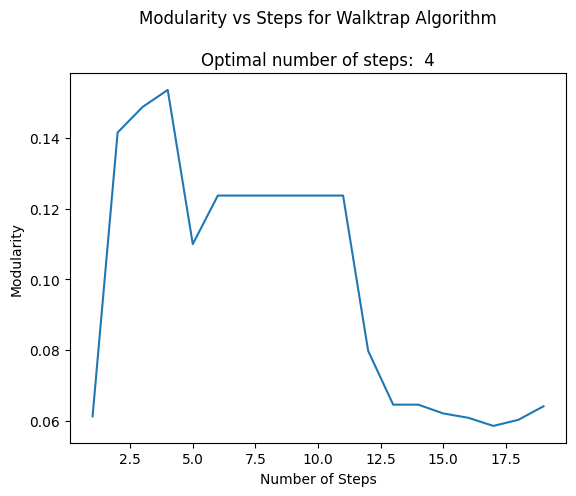

Optimal number of steps: 4


In [220]:

ig_graph = ig.Graph.from_networkx(G_filtered)

# Set the range of steps to test
steps_range = range(1, 20)

# Calculate modularity for different steps
modularity_values = []
for steps in steps_range:
    walktrap = ig_graph.community_walktrap(steps=steps)
    communities = walktrap.as_clustering()
    community_sets = [set(community) for community in communities]
    
    membership = [0] * len(ig_graph.vs)
    for i, community in enumerate(community_sets):
        for node in community:
            membership[node] = i
            
    modularity = ig_graph.modularity(membership)
    modularity_values.append(modularity)

# Plot modularity vs steps
plt.plot(steps_range, modularity_values)
plt.xlabel('Number of Steps')
plt.ylabel('Modularity')
#plt.title('Modularity vs Steps for Walktrap Algorithm')
plt.title(f'Modularity vs Steps for Walktrap Algorithm\n\nOptimal number of steps:  {optimal_steps}')

plt.savefig("steps_walktrap.png", dpi=300, bbox_inches="tight")
plt.show()

# Find the optimal number of steps
optimal_steps = steps_range[modularity_values.index(max(modularity_values))]

# Print the optimal number of steps
print("Optimal number of steps:", optimal_steps)

In [211]:
# Apply the Walktrap algorithm
ig_graph = ig.Graph.from_networkx(G_filtered)
walktrap = ig_graph.community_walktrap(steps=4)
communities = walktrap.as_clustering()
print(walktrap)

Dendrogram, 55 elements, 54 merges


In [210]:
print(communities)

Clustering with 55 elements and 10 clusters
[ 0] 0, 6, 14, 29, 30, 41, 48, 54
[ 1] 1, 4, 7, 15, 18, 25, 42, 51, 52
[ 2] 2, 34, 39
[ 3] 3, 17
[ 4] 5, 8, 9, 26, 27, 28, 31, 32, 36, 37
[ 5] 10, 11, 12, 13, 16, 19, 21, 22, 23, 24, 33, 35, 38, 40, 47
[ 6] 20, 45
[ 7] 43, 44, 50
[ 8] 46, 49
[ 9] 53


In [212]:
import networkx as nx
import igraph as ig

# Assuming you have a graph G
# Convert NetworkX graph to an igraph graph
ig_graph = ig.Graph.from_networkx(G)

# Apply the Walktrap algorithm
walktrap = ig_graph.community_walktrap(steps=11)
communities = walktrap.as_clustering()

# Filter clusters with more than 1 node
filtered_communities = [community for community in communities if len(community) > 3]

# Print filtered communities
for i, community in enumerate(filtered_communities):
    print(f"Community {i + 1}: {community}")

Community 1: [0, 4, 8, 15, 17, 18, 19, 20, 22, 23, 25, 27, 29, 30, 31, 38, 40, 41, 42, 44, 49, 50, 51, 53, 54, 56, 60, 61, 65, 68, 71, 74, 76, 78, 84, 86, 88, 92, 93, 98, 99, 106]
Community 2: [1, 7, 11, 16, 32, 33, 36, 48, 52, 83, 85, 87, 89, 95, 101, 103]
Community 3: [6, 21, 34, 43, 64, 81, 90, 97, 100, 105]


In [213]:
print(filtered_walktrap)

Dendrogram, 68 elements, 67 merges


In [221]:
# Create a simple graph
vertices = [0, 1, 2, 3, 4, 5]
edges = [(0, 1), (0, 2), (1, 2), (3, 4), (4, 5), (3, 5)]

g = ig.Graph(vertex_attrs={"label": vertices}, edges=edges)

# Apply the Walktrap algorithm
walktrap = g.community_walktrap(steps=4)
dendrogram = walktrap.as_clustering().dendrogram()

# Plot the dendrogram
ig.plot(dendrogram, bbox=(300, 300), margin=40)
plt.show()

AttributeError: 'VertexClustering' object has no attribute 'dendrogram'

In [223]:
# Create a simple graph
vertices = list(range(55))
edges = [(0, 6), (0, 14), (0, 29), (0, 30), (0, 41), (0, 48), (0, 54),
         (1, 4), (1, 7), (1, 15), (1, 18), (1, 25), (1, 42), (1, 51), (1, 52),
         (2, 34), (2, 39),
         (3, 17),
         (5, 8), (5, 9), (5, 26), (5, 27), (5, 28), (5, 31), (5, 32), (5, 36), (5, 37),
         (10, 11), (10, 12), (10, 13), (10, 16), (10, 19), (10, 21), (10, 22), (10, 23), (10, 24), (10, 33), (10, 35), (10, 38), (10, 40), (10, 47),
         (6, 20), (6, 45),
         (43, 44), (43, 50),
         (46, 49)]

g = ig.Graph(vertex_attrs={"label": vertices}, edges=edges)

# Apply the Walktrap algorithm
walktrap = g.community_walktrap(steps=4)
clustering = walktrap.as_clustering()

# Plot the dendrogram
dendrogram = walktrap.dendrogram
dendrogram.plot()

AttributeError: 'VertexDendrogram' object has no attribute 'dendrogram'

In [224]:
# Create a simple graph
vertices = list(range(55))
edges = [(0, 6), (0, 14), (0, 29), (0, 30), (0, 41), (0, 48), (0, 54),
         (1, 4), (1, 7), (1, 15), (1, 18), (1, 25), (1, 42), (1, 51), (1, 52),
         (2, 34), (2, 39),
         (3, 17),
         (5, 8), (5, 9), (5, 26), (5, 27), (5, 28), (5, 31), (5, 32), (5, 36), (5, 37),
         (10, 11), (10, 12), (10, 13), (10, 16), (10, 19), (10, 21), (10, 22), (10, 23), (10, 24), (10, 33), (10, 35), (10, 38), (10, 40), (10, 47),
         (6, 20), (6, 45),
         (43, 44), (43, 50),
         (46, 49)]

g = ig.Graph(vertex_attrs={"label": vertices}, edges=edges)

# Apply the Walktrap algorithm
walktrap = g.community_walktrap(steps=4)
clustering = walktrap.as_clustering()

# Convert to dendrogram object and plot
dendrogram = clustering.as_dendrogram()
dendrogram.plot()

AttributeError: 'VertexClustering' object has no attribute 'as_dendrogram'